### Models X2 | created 01/07/2022 | generalisation of Models X
> This notebook was created with the goal of the computational analysis of the spot properties output of the Opera.

##### Imports

In [45]:
# General
import os
import sys
import pickle
import random
import string
import numpy as np
import pandas as pd
from datetime import date
from plotnine import *
from plotnine import __version__ as p9__version__
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import __version__ as sk__version__

print("python", sys.version,
      "\nnumpy", np.__version__,
      "\npandas", pd.__version__,
      "\nplotnine", p9__version__,
      "\nstatsmodels", sm.__version__,
      "\nsklearn", sk__version__)

# Random Forest
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

python 3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15) [MSC v.1929 64 bit (AMD64)] 
numpy 1.22.3 
pandas 1.4.2 
plotnine 0.8.0 
statsmodels 0.13.2 
sklearn 1.1.1


#### 1) Pre-Processing
This is the selection of the right columns from the Opera output file.

In [2]:
def opera_to_df(input):
    # Import Tab separated opera file
    raw_df = pd.read_csv(input, sep = '\t', skiprows = 9)       # Read file (txt or csv) and skip header
    raw_df = raw_df.dropna(axis = 'columns')                    # Remove non-value columns
    return raw_df 

def filter_frame(df, col_idx):
    df_out = df[df['Column'] == col_idx]    # Select Column
    return df_out

##### 2) Model Fitting

In [83]:
def attach_trc(df, path_annotations):
    ls_trc = []

    with open(path_annotations) as f:
        for line in f:
            ls_trc.append(int(line))
    df['trc'] = ls_trc

def get_rfc_model(df, features, prediction, estimators, depth_max):
    y = df[prediction]
    X = df[features]

    c = RandomForestClassifier(n_estimators = estimators, max_depth = depth_max)
    m_rfc = c.fit(X,y)

    p = m_rfc.predict(X)

    print(classification_report(y,p))
    ConfusionMatrixDisplay.from_predictions(y, p)

    return m_rfc

def store_rfc_model(model, path, name):
    # Identifier
    date_raw = date.today()
    d1 = date_raw.strftime("%d%m%y")

    identifier = d1 + "_" + name
    folderpath = os.path.join(path, identifier).replace("\\","/")
    os.mkdir(folderpath)

    descriptor =    str(model.feature_names_in_) + \
                    str(model.feature_importances_) + "\n" + \
                    "Features: " + str(model.n_features_) + "\n" + \
                    "Max Depth: " + str(model.max_depth)

    # Write Descriptor
    with open(folderpath + '/readme.txt', 'w') as f:
        f.write(descriptor)

    # Write Model
    pickle.dump(model, open(folderpath + f'/{identifier}.rfc', "wb"))


In [79]:
def getModel(input, rc, in_out):
    # 1) Obtain proper cuts
    df_clc = opera_to_df(in_out[0] + '/' + input)
    
    if len(rc) > 1:
        clc_pos = df_clc[df_clc['Row'] == rc[0]]
        clc_pos = df_clc[df_clc['Column'] == rc[1]]
    else:
        clc_pos = df_clc[df_clc['Column'] == rc[0]]

    # 2) Obtain Annotation Data
    attach_trc(clc_pos, in_out[0] + '/cep.txt')

    prediction = ['trc']
    features = ['coloc AR - Spot Contrast', 'coloc AR - Spot Area [px²]', 'coloc AR - Relative Spot  Intensity', 'coloc AR - Corrected Spot  Intensity', 'coloc AR - Spot To Region Intensity']

    m_rfc = get_rfc_model(clc_pos, features, prediction, estimators = 10, depth_max = 5)
    return m_rfc


              precision    recall  f1-score   support

           0       0.92      0.98      0.95       162
           1       0.93      0.78      0.85        65

    accuracy                           0.92       227
   macro avg       0.92      0.88      0.90       227
weighted avg       0.92      0.92      0.92       227



C:\Users\Student\AppData\Local\Temp\ipykernel_10088\3768249418.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Student\AppData\Local\Temp\ipykernel_10088\3768249418.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
c:\Users\Student\Desktop\LocalEnvs\localenv\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.


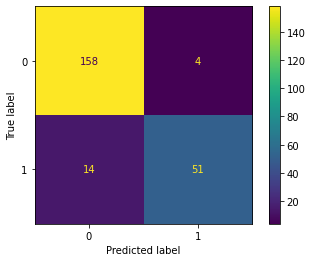

In [84]:
# MODEL GEN
in_out = ['data/0206_assay_novel/input_data', 'data/0206_assay_novel/output_data']
path = 'Objects_Population - coloc AR.txt'
model = getModel(path, [8], in_out)

store_rfc_model(model, in_out[1], 'prime')

In [88]:
features = ['coloc AR - Spot Contrast', 'coloc AR - Spot Area [px²]', 'coloc AR - Relative Spot  Intensity', 'coloc AR - Corrected Spot  Intensity', 'coloc AR - Spot To Region Intensity']

### Predictions
##### 1606 with 0206 prime

In [92]:
# LOAD model
model = pickle.load(open('data/0206_assay_novel/output_data/010722_prime/010722_prime.rfc', 'rb'))

# LOAD data
ar_coloc_1606 = opera_to_df('data/1606_assay/input_data/Objects_Population - coloc AR.txt')
ar_wt_pos_1606_1 = ar_coloc_1606[ar_coloc_1606['Column'] == 4]

X = ar_wt_pos_1606_1[features]

trc_wt = model.predict(X)
ar_wt_pos_1606_1['trc'] = trc_wt

ar_wt_pos_1606_1_view = ar_wt_pos_1606_1[ar_wt_pos_1606_1['trc'] == 1]
ar_wt_pos_1606_1_view.to_csv('data/1606_assay_novel/output_data/ar_wt_4_view.csv')

C:\Users\Student\AppData\Local\Temp\ipykernel_10088\2299552489.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [121]:
ls_run_1 = []

with open('data/1606_assay_novel/output_data/ran_lab_0206_prime_1.txt', 'r') as f:
    for line in f:
        ls_run_1.append(int(line))

In [122]:
full_size = len(ls_run_1)
full_fold = ls_run_1.count(1) + ls_run_1.count(0)
positive_fold = ls_run_1.count(1)

print(f'Fold Positive Percentage: {positive_fold/full_fold * 100} %')
print(full_fold)

Fold Positive Percentage: 76.0 %
50


In [116]:
a = [38, 177, 186, 23, 95, 90, 239, 221, 188, 287, 34, 272, 206, 270, 105, 208, 49, 44, 162, 308, 86, 111, 4, 176, 140, 194, 229, 46, 132, 286, 80, 91, 253, 215, 310, 236, 98, 19, 264, 281, 85, 165, 245, 97, 61, 244, 40, 83, 79, 202]
len(set(a))

50